# Plotting animated GIFs from time series imagery

**What does this notebook do?** 

This notebook demonstrates how to import a time series of DEA cloud-free Landsat imagery from multiple sensors (i.e. Landsat 5, 7 and 8) as an xarray dataset, and then plot the data as an animated time series GIF and a transitioning/fading GIF that compares two timesteps. Animations can be produced as either GIFs or MP4s for any area in Australia using a standard datacube query.

**Required inputs**

This example uses three external functions called `load_clearlandsat`, `animated_timeseries` and `animated_fade`. These functions are available in the Scripts folder of the [dea-notebooks Github repository](https://github.com/GeoscienceAustralia/dea-notebooks/tree/master/Scripts). Note that these functions have been developed by DEA users, not the DEA development team, and so are provided without warranty. If you find an error or bug in the functions, please either create an 'Issue' in the Github repository, or fix it yourself and create a 'Pull' request to contribute the updated function back into the repository (See the repository [README](https://github.com/GeoscienceAustralia/dea-notebooks/blob/master/README.rst) for instructions on creating a Pull request).

**Date:** May 2018

**Author:** Robbi Bishop-Taylor

In [5]:
# Import modules
import datacube 
import sys

# Import external dea-notebooks functions using relative link to Scripts directory
sys.path.append('../Scripts')
import DEADataHandling
import DEAPlotting

# Set up datacube instance
dc = datacube.Datacube(app='Time series animation')
# dc = datacube.Datacube(config='/home/561/rt1527/preprod_dc.conf')



## Set up datacube query
Define the query bounds for datacube extraction using a dict. This should include `x` and `y` limits, potentially a list of `measurements` (i.e. the bands you want to extract like 'red', 'green', 'blue'; this significantly speeds up the import) and a `time` extent. If no `time` is given, the function defaults to all timesteps available to all sensors (e.g. 1987-2018).

In [36]:
from datacube.utils import geometry
from datacube.utils.geometry import CRS

# Set up analysis data query using a buffer around a lat-long point
lat, lon, buffer = -32.622049, 142.074858, 10000
x, y = geometry.point(lon, lat, CRS('WGS84')).to_crs(CRS('EPSG:3577')).points[0]
query = {'x': (x - buffer, x + buffer),
         'y': (y - buffer, y + buffer),    
         'time': ('2007-06-01', '2016-12-30'),
         'crs': 'EPSG:3577'}


## Extract cloud-free clear Landsat observations from all sensors
Use the `load_clearlandsat` function to load Landsat observations and PQ data for multiple sensors (i.e. ls5, ls7, ls8), and return a single xarray dataset containing only observations that contain greater than a specified proportion of clear pixels. This uses `dask` to only load in the filtered observations, and results in a visually appealing time series of observations that are not affected by cloud!

Generating 61 frame animation (i.e. timesteps in shortest dataset)
    Exporting animation to /home/561/rt1527/Transfer/animation_double2.gif


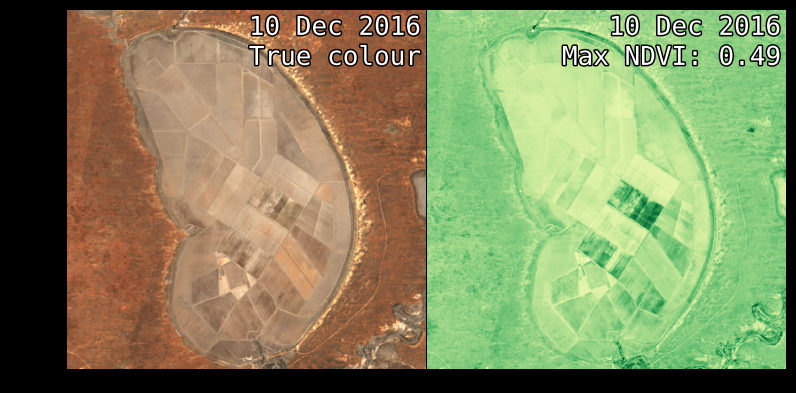

In [53]:
# Custom mask that includes only cloudy or cloud shadowed pixels with data for all bands
custom_mask = {'cloud_acca': 'no_cloud', 
               'cloud_fmask': 'no_cloud', 
               'cloud_shadow_acca': 'no_cloud_shadow',
               'cloud_shadow_fmask': 'no_cloud_shadow',
               'contiguous': True}

# # Load in data
# ds1 = DEADataHandling.load_clearlandsat(dc=dc, query=query, product='nbart', 
#                                         bands_of_interest=['red', 'green', 'blue', 'nir'], 
#                                         masked_prop=0.99, mask_dict=custom_mask, apply_mask=False)  
# ds2 = DEADataHandling.load_clearlandsat(dc=dc, query=query, product='nbart', 
#                                         bands_of_interest=['red', 'green', 'blue', 'nir'], 
#                                         masked_prop=0.99, mask_dict=custom_mask, apply_mask=False) 

# Create custom annotation
# title1 = ['{}% cloud'.format(100 - int(i * 100)) for i in ds1.data_perc.values.tolist()]
ds1['ndvi'] = (ds1.nir - ds1.red) / (ds1.nir + ds1.red)
ds1['ndwi'] = (ds1.green - ds1.nir) / (ds1.green + ds1.nir)


import numpy as np
title1=["Max NDVI: {0:.2f}".format(i) for i in ds1['ndwi'].max(dim=['x','y']).values.tolist()]


# Animate datasets    
DEAPlotting.animated_doubletimeseries(ds1=ds1, ds2=ds1, 
                          output_path='/home/561/rt1527/Transfer/animation_double2.gif',
                          width_pixels=650,
                          bands1=['red', 'green', 'blue'], bands2=['ndvi'], 
                          reflect_stand1=2800, reflect_stand2=1500, 
                          title1="True colour", title2=title1,
                          onebandplot_kwargs2={'cmap':'YlGn', 'vmin':0.0, 'vmax':0.5},
                          annotation_kwargs1={'fontsize':26}, annotation_kwargs2={'fontsize':26})

# DEAPlotting.animated_timeseries(ds=ds1,  
#                     output_path='/home/561/rt1527/Transfer/animation_single.mp4',
#                     bands=['ndvi'], reflect_stand=3000, title='NDVI', 
#                     show_date=True, onebandplot_kwargs={'cmap':'YlGn', 'vmin':0.0, 'vmax':0.1}) 


In [ ]:
ds1['test'] = 0
ds1['test2'] = 50
ds1

animated_timeseries(ds=ds1,  
                    output_path='/home/561/rt1527/Transfer/animation_single.mp4',
                    bands=['test', 'blue', 'test2'], reflect_stand=1000, title=title1, 
                    show_date=True, interval=100)

In [ ]:
query = {'x': (1625908, 1638908),
         'y': (-4023753, -4010753),    
         'time': ('2015-01-01', '2016-12-30'),
         'crs': 'EPSG:3577',
         'output_crs': 'EPSG:4326', 
         'resolution': (0.000278, 0.000278)}

dc.load(product="ls8_level1_scene", **query)
# y +buffer

In [ ]:
lat, lon = -35.7088156139, 150.121438256

query = {'x': (lon - 0.1, lon + 0.1),
         'y': (lat + 0.1, lat - 0.1),    
         'time': ('2015-01-01', '2016-12-30'),
         'output_crs': 'EPSG:4326',
         'resolution': (0.000278, 0.000278)}

dc.load(product="ls8_level1_scene", **query)

In [ ]:
def _ds_to_arrraylist(ds, bands, reflect_stand):   

    array_list = []
    for i, timestep in enumerate(ds.time):

        # Select single timestep from the data array
        ds_i = ds.isel(time = i)

        # Create new three band array
        y, x = ds_i[bands[0]].shape

        if len(bands) == 1:    

            # Create new three band array
            img_toshow = ds_i[bands[0]].values

        else:

            rawimg = np.zeros((y, x, 3), dtype=np.float32)

            # Add xarray bands into three dimensional numpy array
            for band, colour in enumerate(bands):

                rawimg[:, :, band] = ds_i[colour].values

            # Stretch contrast using defined reflectance standardisation; defaults to 5000
            img_toshow = (rawimg / reflect_stand).clip(0, 1)

        array_list.append(img_toshow)

    return(array_list)




In [ ]:
bands=["red"]

ds = ds1[["red"]]





# Select single timestep from the data array
ds_i = ds.isel(time = 0)

# Create new three band array
img_toshow = ds_i[bands[0]].values
img_toshow

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.patheffects as path_effects

text = plt.text(0.5, 0.5, 'Hello path effects world!',
                path_effects=[path_effects.withSimplePatchShadow()])

plt.plot([0, 3, 2, 5], linewidth=5, color='blue',
         path_effects=[path_effects.SimpleLineShadow(),
                       path_effects.Normal()])
plt.show()